# 0. Marking.

***IMPORTANT***: Save a copy of this notebook into your Drive before you start.
- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).

Please submit a zip file, containing both parts, consiting of of:
1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

### Globals.


In [1]:
# The simulation component of the flower framework uses RAY under the hood.
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching torch torchvision matplotlib gdown tqdm ray=="2.6.3" seaborn
# The following is just needed to show the folder tree

In [2]:
from typing import *

### Imports.


In [3]:
# Imports

import json
import numbers
import random
from collections import OrderedDict, defaultdict
from datetime import datetime, timezone
from enum import IntEnum
from pathlib import Path
from typing import Optional

import flwr as fl
import gdown
import numpy as np
import seaborn as sns
import torch
from flwr.client import Client
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg
from flwr.server.strategy import Strategy
from matplotlib import pyplot as plt
from numpy.linalg import norm
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore


def convert(o):
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)


PathType = Optional[Union[Path, str]]


def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

/home/xt0r3-user/anaconda3/envs/fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-02 18:49:55,910	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
home_dir = content if (content := Path("/content")).exists() else Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )

# Decompress dataset
if not dataset_dir.exists():
    !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
    print(f"Dataset extracted in {dataset_dir}")

In [5]:
if not (home_dir / "common").exists():
    ! git clone "https://github.com/camlsys/L361-Federated-Learning.git" temp_repo

    # Copy the folder to the current directory
    ! cp -r "temp_repo/labs/common" {home_dir}

    # Delete the cloned repository
    ! rm -rf temp_repo

(home_dir / "__init__.py").open(mode="a+")

<_io.TextIOWrapper name='/home/xt0r3-user/cambridge/partii/lent/federated_learning/labs/__init__.py' mode='a+' encoding='UTF-8'>

In [6]:
from common.client_utils import Net
from common.client_utils import get_network_generator_cnn as get_network_generator
from common.client_utils import load_FEMNIST_dataset, test_FEMNIST, train_FEMNIST

# 5. Building a Flower FL client.

Our first client abstraction shall be as simple as possible and will require adjustment to match the structure that the flower framework expects. However, it shall be conceptually identical and require only light API changes.

Moving from centralised ML to server-client FL requires us to provide a means of communication between the respective server and clients. The Flower Framework is ML-framework agnostic and allows various means of transmitting model parameters in the federated network. Since you may have limited resources in these labs, we will only tangentially follow the Flower framework while keeping the computational requirements to a minimum.

The simplest and most common encoding for models is the mere transmission of model parameters as NumPy arrays instead of the stateful PyTorch models. The following functions allow for seamless conversions between the two.

In [7]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Function to put a set of parameters into the model object.

    Args:
        net (Module): model object.
        parameters (NDArrays): set of parameters to put into the model.

    Returns
    -------
        Module: updated model object.
    """
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights, strict=False)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Function to get the current model parameters as NDArrays.

    Args:
        net (Module): current model object.

    Returns
    -------
        NDArrays: set of parameters from the current model.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

With them in place, making the client abstraction compatible with Flower requires only a bit of boilerplate such as allowing NumPy arrays to be received and sent instead of PyTorch models. To achieve this, we provide a model generator capable of creating a network and using the received parameters.

To keep client objects light in the memory when not used by the Flower FL simulator, the model generator is only called as needed for either `fit` or `evaluate`.

In [8]:
class FlowerRayClient(fl.client.NumPyClient):
    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Function to initialise the client with its unique id
        and the directory from which it can load its data.

        Args:
            cid (int): Unique client id for a client used to map it to its data partition
            partition_dir (Path): The directory containing data for each client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        print("cid: ", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: Dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Loads weights inside the network.

        Args:
            parameters (NDArrays): set of weights to be loaded.

        Returns
        -------
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: Dict[int, Scalar]) -> NDArrays:
        """Returns weights from a given model. If no model is passed, then a
        local model is created. This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Args:
            config (Dict[int, Scalar]): dictionary containing configuration info.

        Returns
        -------
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns
        -------
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[float, int, dict]:
        """Function which receives and tests a model on the local client data using parameters from the config dict

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns
        -------
            Tuple[float, int, dict]: Returns the loss accumulate during testing, the size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: Dict[str, Scalar], name: str) -> DataLoader:
        """Creates the data loader using the specified config parameters

        Args:
            config (Dict[str, Scalar]): Dictionary containing dataloader and dataset parameters
            mode (str): Load the training or testing set for the client

        Returns
        -------
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_FEMNIST_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: Dict[str, Scalar]
    ) -> float:
        return train_FEMNIST(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=config["max_batches"],
        )

    def _test(
        self, net, test_loader: DataLoader, config: Dict[str, Scalar]
    ) -> Tuple[float, float]:
        return test_FEMNIST(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=config["max_batches"],
        )

    def get_properties(self, config: Dict[str, Scalar]) -> Dict[str, Scalar]:
        """Returns properties for this client.

        Args:
            config (Dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns
        -------
            Dict[str, Scalar]: Returned properties.
        """
        # pylint: disable=unused-argument
        return self.properties

    def get_train_set_size(self) -> int:
        """Returns the client train set size.

        Returns
        -------
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore

    def get_test_set_size(self) -> int:
        """Returns the client test set size.

        Returns
        -------
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore

The underlying FL simulator used by Flower is based on [Ray](https://www.ray.io/). It expects each client only to require a client ID for instantiation. Therefore, using the following generator function, we can determine the specific network used for FL together with the FEMNIST partition to which the `cid` refers.

While we will not use `Ray` in this lab due to its heavyweight nature, we will keep all code API compatible with the default flower framework.

In [9]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to be of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

To ensure the Flower client behaves the same as our simple demo client, a simple test using the centralised partition we defined earlier should suffice.

In [10]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(
    network_generator, centralized_partition
)  # type: ignore
centralized_flower_client = centralized_flower_client_generator(0)

cid:  0


In [11]:
centralized_train_config: Dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
print(train_metrics)

{'train_loss': 0.11736562751233577}


In [12]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
print(loss, test_metrics)

  4%|█▋                                      | 100/2329 [00:01<00:25, 86.61it/s]

369.5580060482025 {'local_accuracy': 0.059375}


# 6. FL with natural partitions

Given its naturally-partitioned nature, we can easily construct a realistic FL experiment by mapping clients one-to-one with the writers of the original symbols.

To pursue this aim, we shall use the “naturally federated” partition instead of the "centralised” one. We are then using the entire `train.csv` and `test.csv` contained in the subfolders of `client_data_mappings/fed_natural`. Each subfolder is named after the clients' ID in the dataset, i.e., from `0` to `3229`.

To guarantee that each client has sufficient training data to participate meaningfully, a common practice is to set a lower bound on the number of samples a selected client is allowed to have. Generally, this threshold should be equivalent to at least one batch. We will now implement a function to sample clients from the federation that satisfies the abovementioned filter in the train set.

In [13]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Function to randomly sample clients.
    A filter on the client train set size is performed.

    Args:
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns
    -------
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[
        [int], FlowerRayClient
    ] = get_flower_client_generator(
        network_generator, federated_partition
    )  # type: ignore
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(current_id).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [14]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(
    network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
)  # type: ignore

cid:  2530
cid:  2184
cid:  2907
cid:  1498
cid:  2338
cid:  2399
cid:  2997
cid:  678
cid:  3175
cid:  1363
cid:  1571
cid:  2600
cid:  1473
cid:  1260
cid:  1603
cid:  2855
cid:  839
cid:  3119
cid:  2688
cid:  1494
cid:  447
cid:  1742
cid:  2601
cid:  1633
cid:  267
cid:  2070
cid:  2863
cid:  2736
cid:  1425
cid:  1653
cid:  1652
cid:  3020
cid:  1273
cid:  2718
cid:  73
cid:  1446
cid:  2434
cid:  485
cid:  1887
cid:  1009
cid:  701
cid:  1285
cid:  2782
cid:  2828
cid:  2476
cid:  1872
cid:  2471
cid:  1084
cid:  823
cid:  2243
cid:  275
cid:  2614
cid:  2152
cid:  2534
cid:  2364
cid:  3168
cid:  179
cid:  295
cid:  1668
cid:  2674
cid:  2538
cid:  220
cid:  2767
cid:  70
cid:  2600
cid:  806
cid:  807
cid:  428
cid:  1167
cid:  805
cid:  1852
cid:  3068
cid:  2329
cid:  1287
cid:  51
cid:  2501
cid:  1366
cid:  1770
cid:  2343
cid:  937
cid:  2251
cid:  187
cid:  3178
cid:  2274
cid:  2975
cid:  2645
cid:  1258
cid:  875
cid:  2504
cid:  740
cid:  2167
cid:  2157
cid:  2164
ci

Now, to test that the newly partitioned clients can be trained.

In [15]:
one_epoch_config: Dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

five_epoch_config: Dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [16]:
num_clients = 4
clients = random.sample(list(range(total_clients)), num_clients)

In [17]:
generated_clients = [federated_client_generator(cid) for cid in clients]

cid:  3175
cid:  51
cid:  1668
cid:  1498


In [18]:
trained_models = [
    fit_client_seeded(client, seed_model_params, one_epoch_config)
    for client in generated_clients
]

In [19]:
trained_model_parameters = [model for model, *rest in trained_models]
trained_model_metrics = [rest for _, *rest in trained_models]
print(trained_model_metrics)

[[4, {'train_loss': 0.12444548681378365}], [11, {'train_loss': 0.12350456416606903}], [3, {'train_loss': 0.12324738750855128}], [4, {'train_loss': 0.12358858622610569}]]


In [20]:
five_epoch_trained_models = [
    fit_client_seeded(client, seed_model_params, five_epoch_config)
    for client in generated_clients
]

five_epoch_trained_model_parameters = [
    model for model, *rest in five_epoch_trained_models
]
five_epoch_trained_model_metrics = [rest for _, *rest in five_epoch_trained_models]
print(five_epoch_trained_model_metrics)

[[4, {'train_loss': 0.10077909007668495}], [11, {'train_loss': 0.11037736318328163}], [3, {'train_loss': 0.10799879332383473}], [4, {'train_loss': 0.09798731282353401}]]


**Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

If we index the weights of an ML model consecutively, with the assumed architecture being the same, we can visualize it as a single flattened 1-D vector. One, highly imperfect, metric for determining how similar two ML models are is cosine similarity. We can use this metric to compare the models our clients produce are.

1. Write functions to:
    - Flatten the `NDArrays` objects into a single 1-D vector.
        - The function `flatten` concatenates the parameter arrays in order into one big, flattened array. Note that this works if we have a ragged array/`NDArray` of `NDArrays` or scalars.
    - Compute the cosine similarity of two 1-D vectors based on their inner product and norms.
        - This function first flattens any ragged arrays.
        - The formula for the cosine similarity is $$\frac{v_1 \cdot v_2}{|v_1| |v_2|}$$, where $(\cdot)$ denotes the dot product and $|v|$ denotes the length of the vector. The appropriate functions in numpy are `np.dot` and `np.linalg.norm` which are used in the function `cosine_similarity` to compute the cosine similarity.
2. Compute a similarity matrix between all client models and plot it.
    - We use a nested for loop to compute the pairwise similarities, then use `sns.heatmap` to plot the heatmap of the cosine similarities.
3. What happens to the similarity matrix if you increase the number of local epochs that clients train for to 5 from 1? Why do you think that is?
    - The off-diagonal elements become smaller, as the local models train for more epochs on their own datasets, making them diverge further from the initial shared model.
    - Note that I have saved the initially generated clients in a list called `generated_clients` to ensure a fair comparison of the clients.
>You may want to save the parameters calculated here separately from the deault ones as both sets will be needed in future questions.

In [21]:
def flatten(arrs: List[np.ndarray]):
    return np.concatenate([np.array(item).flatten() for item in arrs], axis=0)

In [22]:
def cosine_similarity(ragged_v1, ragged_v2):
    v1 = flatten(ragged_v1)
    v2 = flatten(ragged_v2)
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

In [23]:
def get_pairwise_similarities(params):
    similarities = []

    for m1 in tqdm(params):
        similarities.append([])
        for m2 in params:
            similarities[-1].append(cosine_similarity(m1, m2))

    return similarities

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1366.22it/s]


[[Text(0.5, 0, '94'),
  Text(1.5, 0, '74'),
  Text(2.5, 0, '58'),
  Text(3.5, 0, '3')],
 [Text(0, 0.5, '94'),
  Text(0, 1.5, '74'),
  Text(0, 2.5, '58'),
  Text(0, 3.5, '3')],
 Text(0.5, 1.0, '1 epoch similarity matrix')]

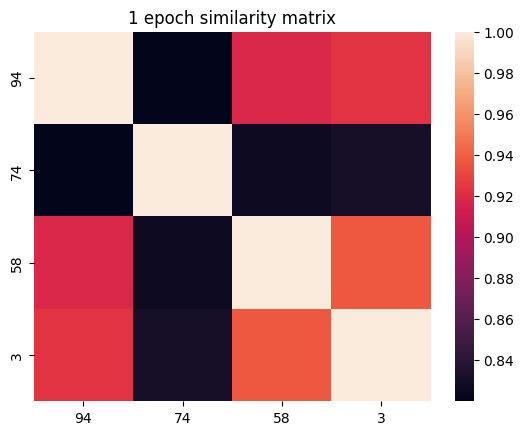

In [24]:
sns.heatmap(get_pairwise_similarities(trained_model_parameters)).set(
    xticklabels=clients, yticklabels=clients, title="1 epoch similarity matrix"
)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 922.69it/s]


[[Text(0.5, 0, '94'),
  Text(1.5, 0, '74'),
  Text(2.5, 0, '58'),
  Text(3.5, 0, '3')],
 [Text(0, 0.5, '94'),
  Text(0, 1.5, '74'),
  Text(0, 2.5, '58'),
  Text(0, 3.5, '3')],
 Text(0.5, 1.0, '5 epoch similarity matrix')]

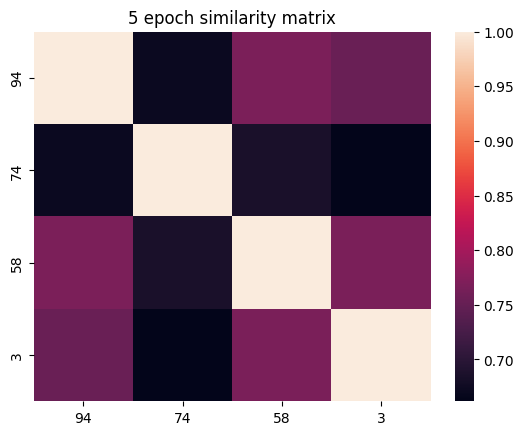

In [25]:
sns.heatmap(get_pairwise_similarities(five_epoch_trained_model_parameters)).set(
    xticklabels=clients, yticklabels=clients, title="5 epoch similarity matrix"
)

**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

One reason that cosine similarity is an imperfect metric is because it considers weights from different layers to be equally important to the model in terms of its behavior and performance. We can thus create a slightly more detailed picture by tracking the cosine similarity across layers.

1. Create a function which computes the pairwise cosine similarity between flattened model layers across clients, i.e. the cosine similarity between the flattened $l_i$ in `client_x` and the flattened $l_i$ in `client_y`.
2. Plot the similarity of the models at each layer between the most similar client pair and the most disimilar client pair (as determined by the multi-epoch experiment) using the **one-epoch models**, how do the curves you observe relate to the general cosine similarity you computed for the flattened models.
3. What happens to the curves if you increase the number of local epochs to 5? How does this behavior relate to what you observed in the previous exercise ?
4. **Optional**: Do you think there is any connection to the underlying architecture? Why? Repeat the above experiments using an MLP such as the one provided by the  `get_network_generator_mlp` in `client_utils` and compare results against the CNN.

In [26]:
def get_pairwise_cos_similarity(c1, c2, layer_num, params):
    return cosine_similarity(
        flatten(params[c1][layer_num]), flatten(params[c2][layer_num])
    )


get_pairwise_cos_similarity(1, 3, 1, trained_model_parameters)

0.97537756

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 811.98it/s]


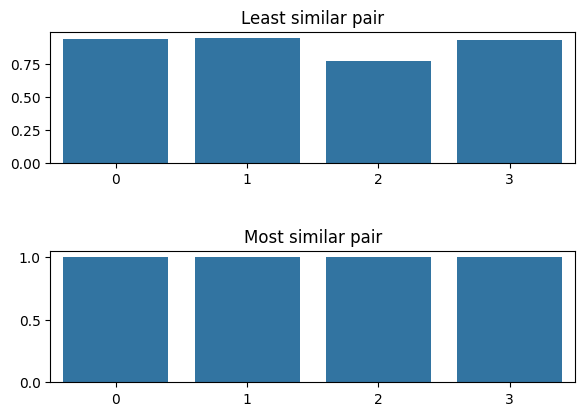

In [27]:
A = np.array(get_pairwise_similarities(trained_model_parameters))
mini_c1, mini_c2 = np.unravel_index(A.argmin(), A.shape)
maxi_c1, maxi_c2 = np.unravel_index(A.argmax(), A.shape)

fig, ax = plt.subplots(2)
sns.barplot(
    [
        get_pairwise_cos_similarity(
            mini_c1, mini_c2, layer_num, trained_model_parameters
        )
        for layer_num in range(len(trained_model_parameters))
    ],
    ax=ax[0],
).set_title("Least similar pair")
sns.barplot(
    [
        get_pairwise_cos_similarity(
            maxi_c1, maxi_c2, layer_num, trained_model_parameters
        )
        for layer_num in range(len(trained_model_parameters))
    ],
    ax=ax[1],
).set_title("Most similar pair")
plt.tight_layout(pad=3)

# 7. Federated training with Flower

The two basic blocks of synchronous server-client FL systems are:
- A client with some local training method and data---i.e., SGD. This is what we have built thus far.
- A server which coordinates training sends the federated model to clients at the start of each round and aggregates model updates at the end of each round.


![picture](https://drive.google.com/uc?id=1Db_Uys2QPFHW6cMranZ_QXo2vC0A_C-N)

While the variety of client local training methods is as wide as ML, server training varies depending on which **aggregation algorithm** combines the model updates and forms the new federated model. Flower refers to the component that controls the aggregation and train/test configuration as a **strategy**. For our labs, strategy and aggregation algorithms will be used interchangeably.

The strategy we shall use is [FedAvg](https://arxiv.org/abs/1602.05629):

$G^{r+1} = G^{r} + \eta \left( \sum_{k=1}^{m} p_k (G^r_k - G^{r}) \right)$,

where $G^{r+1}$ is the model for the next round, which is formed by applying a model update to the current round model $G^{r}$ weighted by the aggregation learning rate $\eta$. The model update is constructed by a sum of client models $G^{r}_k$ where each client model is weighted by $p_k$. The weight factor is usually set to $p_k = \tfrac{n_k}{N}$---the number of training examples held by said client divided by the example count of each client in the round $N = \sum_{k=1}^{m} n_k$.



**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

Averaging models is meant to provide us with a reasonable compromise between the desired models of all clients involved. Given what you already know about the similarity of client models, we can test if this is true.
1. Write a function to compute the weighted average of two `NDArrays` objects while preserving the layer-structure. Use the FedAvg equation above with $p_k = \tfrac{n_k}{N}$.
    - This is the `average_models` function that takes the `client_models` argument, and assumes that it contains the parameters of the models for each client in the same order as they clients appear in the `clients` array. Then it uses `np.average` with the `weights` parameter set to be the `p_k` array to compute the FedAvg weighted average for each layer.
2. Compute the average model of the client models above, both the one-epoch and multi-epoch ones.
    - This is done by simply calling `average_models` on the appropriate set of parameters.
3. Add the averaged models to the cosine-similarity matrices built above, how does it relate to the client models?
    - It is quite similar to every one of the client models. This makes some intuitive sense, as from the perspective of client $i$, the averaged model is $\frac{n_i}{N}$ of itself, and $\frac{N-n_i}{N}$ the original model with some changes. A gross approximation of those changes are that they are some random Gaussian noise with mean $0$ and variance $\sigma^2$. During the weighted average, if these noises are independent, then the total noise will have mean $0$ and variance $\sum_{j=1}^k p_j^2 \sigma^2$, where the squared terms sum to something smaller than $1$, making the divergence from any client smaller. (In the case of all the noise terms being $\frac{1}{k}$, this sum becomes exactly $\frac{\sigma^2}{k}$)
    - The 5-epoch model is less similar than the 1-epoch model, as we allow more divergence for every client model by increasing the number of epochs, but is still quite similar.

In [28]:
def average_models(client_models):
    # Note: np.average normalizes the weights anyway, so there's no need to do that
    p = np.array([client.get_train_set_size() for client in generated_clients])

    average_model = []
    for layer_num in range(len(client_models[0])):
        average_model.append(
            np.average([model[layer_num] for model in client_models], weights=p, axis=0)
        )

    return average_model

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 187.25it/s]


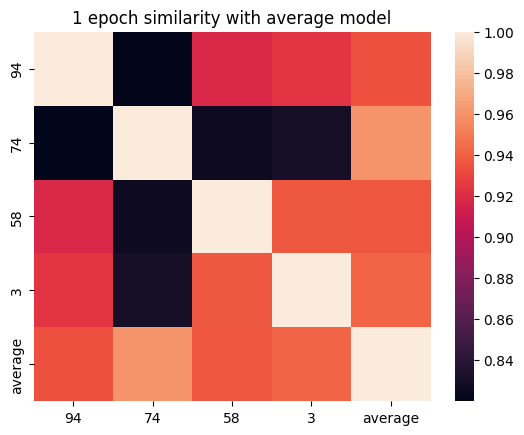

In [29]:
labels = clients + ["averaged_model"]

sns.heatmap(
    get_pairwise_similarities(
        trained_model_parameters + [average_models(trained_model_parameters)]
    )
).set(
    xticklabels=labels,
    yticklabels=labels,
    title="1 epoch similarity with average model",
)

None

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 752.18it/s]


[[Text(0.5, 0, '94'),
  Text(1.5, 0, '74'),
  Text(2.5, 0, '58'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, 'average')],
 [Text(0, 0.5, '94'),
  Text(0, 1.5, '74'),
  Text(0, 2.5, '58'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, 'average')],
 Text(0.5, 1.0, '5 epoch similarity with average model')]

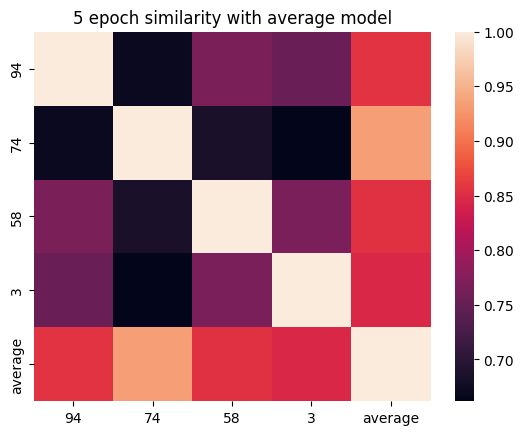

In [30]:
labels = clients + ["averaged_model"]

sns.heatmap(
    get_pairwise_similarities(
        five_epoch_trained_model_parameters
        + [average_models(five_epoch_trained_model_parameters)]
    )
).set(
    xticklabels=labels,
    yticklabels=labels,
    title="5 epoch similarity with average model",
)

**Question 8 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)


1. Repeat the procedure above but for layer-wise cosine similarity and plot the cosine similarity of the two clients client most similar and most disimillar to the averaged model (as determined by the five-epoch condition) using the one-epoch models.
2. How does the relationship change for the higher-epoch condition?

The pieces necessary for starting an FL simulation are now in play; we need to arrange them to fit the Flower API. First, we shall require a separate federated evaluation function which can be called outside the context of a specific client. It will use the centralised test set to be as simple as possible.

In [31]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]:
    """Wrapper function for the external federated evaluation function.
    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Args:
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the model.

    Returns
    -------
        Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]: external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: Dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> Tuple[float, Dict[str, Scalar]]:
        """Evaluation function external to the federation.
        It uses the centralized val set for sake of simplicity.

        Args:
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (Dict[str, Any]): mandatory argument in Flower, can contain some configuration info

        Returns
        -------
            Tuple[float, Dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_FEMNIST_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_FEMNIST(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["max_batches"],
)

In [32]:
def aggregate_weighted_average(metrics: List[Tuple[int, dict]]) -> dict:
    """Generic function to combine results from multiple clients
    following training or evaluation.

    Args:
        metrics (List[Tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))  # type:ignore
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metr for num_examples, metr in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [33]:
# Federated configuration dictionary
federated_train_config: Dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

The only challenge left is the FL simulation itself. In `Flower`, a `Server` object handles this for us by using `Ray` and spawning many heavyweight worker process.

Given the limited-resource scenario in which we find ourselves, we provide you with a slightly modified simulation function which uses a simple thread pool. Feel free to swap it out for the original simulation or replace it with your own implementation if so inclined.

> The server we use is not the default `Flower` server as it returns the model parameters from every single round in a `(round, NDArrays)` tuple.

In [34]:
def save_history(hist: History, name: str):
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[int], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> Tuple[List[Tuple[int, NDArrays]], History]:
    """Wrapper to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

In [35]:
num_rounds = 10

num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5


def run_simulation(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn=federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], Dict[str, Scalar]
    ] = lambda cid: federated_train_config,
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = ndarrays_to_parameters(seed_model_params),
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [int], fl.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> Tuple[List[Tuple[int, NDArrays]], History]:
    print(num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=num_clients_per_round,
        min_evaluate_clients=num_evaluate_clients,
        min_available_clients=num_total_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    simulator_client_generator = lambda cid: federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

In [36]:
parameters_for_each_round, hist = run_simulation()

INFO flwr 2024-02-02 18:50:08,831 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2024-02-02 18:50:08,833 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2024-02-02 18:50:08,835 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2024-02-02 18:50:08,836 | server_returns_parameters.py:84 | Evaluating initial parameters


10


 11%|████▍                                   | 100/891 [00:00<00:05, 137.12it/s]
INFO flwr 2024-02-02 18:50:09,591 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843066215515, {'accuracy': 0.0065625}
INFO flwr 2024-02-02 18:50:09,592 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2024-02-02 18:50:09,593 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


cid:  1494
cid:  3119
cid:  2600
cid:  2399
cid:  1571


DEBUG flwr 2024-02-02 18:50:10,721 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 139.62it/s]
INFO flwr 2024-02-02 18:50:11,461 | server_returns_parameters.py:120 | fit progress: (1, 359.3247103691101, {'accuracy': 0.074375}, 1.8687556229997426)
INFO flwr 2024-02-02 18:50:11,462 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:11,463 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


cid:  1473
cid:  2600
cid:  1363
cid:  1494
cid:  2997


DEBUG flwr 2024-02-02 18:50:12,549 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:04, 159.93it/s]
INFO flwr 2024-02-02 18:50:13,197 | server_returns_parameters.py:120 | fit progress: (2, 341.1436629295349, {'accuracy': 0.074375}, 3.603951249000602)
INFO flwr 2024-02-02 18:50:13,197 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:13,198 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


cid:  2600
cid:  1498
cid:  1260
cid:  1473
cid:  2907


DEBUG flwr 2024-02-02 18:50:14,350 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 148.34it/s]
INFO flwr 2024-02-02 18:50:15,041 | server_returns_parameters.py:120 | fit progress: (3, 351.77633237838745, {'accuracy': 0.070625}, 5.448699208000107)
INFO flwr 2024-02-02 18:50:15,042 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:15,043 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


cid: cid:  2600
 839
cid:  1473
cid:  3119
cid:  1363


DEBUG flwr 2024-02-02 18:50:16,043 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 137.20it/s]
INFO flwr 2024-02-02 18:50:16,796 | server_returns_parameters.py:120 | fit progress: (4, 341.71026515960693, {'accuracy': 0.074375}, 7.203356550000535)
INFO flwr 2024-02-02 18:50:16,797 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:16,798 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


cid:  2530
cid:  2600
cid:  1498
cid:  1603
cid:  678


DEBUG flwr 2024-02-02 18:50:17,823 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 140.63it/s]
INFO flwr 2024-02-02 18:50:18,560 | server_returns_parameters.py:120 | fit progress: (5, 330.27933740615845, {'accuracy': 0.084375}, 8.966829539000173)
INFO flwr 2024-02-02 18:50:18,560 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:18,561 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


cid:  2399
cid:  1571
cid:  1603
cid:  3175
cid:  2997


DEBUG flwr 2024-02-02 18:50:19,508 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 154.40it/s]
INFO flwr 2024-02-02 18:50:20,175 | server_returns_parameters.py:120 | fit progress: (6, 301.83728408813477, {'accuracy': 0.1825}, 10.58190946799914)
INFO flwr 2024-02-02 18:50:20,175 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:20,176 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


cid:  3119
cid:  2907
cid:  839
cid:  2184
cid:  2688


DEBUG flwr 2024-02-02 18:50:21,115 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:04, 159.94it/s]
INFO flwr 2024-02-02 18:50:21,764 | server_returns_parameters.py:120 | fit progress: (7, 270.0823789834976, {'accuracy': 0.32625}, 12.170952389999002)
INFO flwr 2024-02-02 18:50:21,764 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:21,765 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


cid:  1260
cid:  2184
cid:  2530
cid:  2997
cid:  839


DEBUG flwr 2024-02-02 18:50:23,028 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 142.07it/s]
INFO flwr 2024-02-02 18:50:23,752 | server_returns_parameters.py:120 | fit progress: (8, 252.97915017604828, {'accuracy': 0.3740625}, 14.159533023999757)
INFO flwr 2024-02-02 18:50:23,753 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:23,753 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


cid: cid:  1363
 1498
cid:  2997
cid:  1603
cid:  1571


DEBUG flwr 2024-02-02 18:50:24,744 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 156.35it/s]
INFO flwr 2024-02-02 18:50:25,409 | server_returns_parameters.py:120 | fit progress: (9, 233.22660732269287, {'accuracy': 0.45125}, 15.816229628999281)
INFO flwr 2024-02-02 18:50:25,409 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel
DEBUG flwr 2024-02-02 18:50:25,410 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


cid: cid:  1571
 2530
cid:  1260
cid:  678
cid:  2184


DEBUG flwr 2024-02-02 18:50:26,779 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures
 11%|████▍                                   | 100/891 [00:00<00:05, 138.63it/s]
INFO flwr 2024-02-02 18:50:27,524 | server_returns_parameters.py:120 | fit progress: (10, 237.80830574035645, {'accuracy': 0.4084375}, 17.93162614299945)
INFO flwr 2024-02-02 18:50:27,525 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel
INFO flwr 2024-02-02 18:50:27,526 | server_returns_parameters.py:150 | FL finished in 17.933173737999823
INFO flwr 2024-02-02 18:50:27,526 | app.py:250 | app_fit: losses_distributed []
INFO flwr 2024-02-02 18:50:27,527 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10397987990152269, 'all': [(4, 0.10611537098884583), (4, 0.10257652029395103), (5, 0.1034235566854477), (4, 0.10163166746497154), (4, 0.10629136487841606)]}), (2, {'avg': 0.10353077344951175, 'all': [(4, 0.10329127870500088), (5, 0

In [37]:
print(len(parameters_for_each_round))

11


**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Now that an entire FL experiment can be trained, it is worth considering the relationship between the FL model across rounds. If we consider the final model $\theta^N$ obtained after $N$ rounds to be the optimal model $\theta^*$, we can ask how optimization step contributed to reaching $\theta^*$.

1. Run an FL simulation for at-least 50 rounds.
    - This is implemented for us by the `run_simulation` function, we need only change the `num_rounds` parameter.
2. Build a function which reconstitutes the update that must have been applied to model $\theta^t$ in order to obtain $\theta^{t+1}$, assume the `server_learning_rate` was 1.0. We shall call this update $g_t$ and treat it as a pseudo-gradient.
    - This is done in the `pseudo_gradient` function, which takes the difference of all the layers at time `t` and `t+1`. Note that this function preserves the layer structure too, which is not an issue, as `cosine_similarity` will coerce its arguments to be a flattened array.
3. For each round plot the cosine similarity between $g_t$ and the direction of improvement towards $\theta^{*}$ calculated as $\theta^{*} - \theta_t$.
    - This is done in the `correct_gradient` function, which takes the difference of all the layers at time `t` and `T`, the last time step. Note that this function preserves the layer structure too, which is not an issue, as `cosine_similarity` will coerce its arguments to be a flattened array.
4. What do you observe from the plots? Does every update point in the direction of the final model? If not, why do you think that is?
    - Yes, the cosine similarities are always positive, though they are smaller in the beginning. The early unstability makes sense, as in the beginning the models are highly suboptimal, so it's harder to point in the direction of the point where we are going to converge based on the starting loss landscape. Once we start converging to the final valley, the gradients will become more and more aligned. This is achieved because we are using the `AdamW` optimizer, which very broadly speaking tries decreasing the learning rate when the second derivative is small (so when we reach a smoother point of the loss landscape). This tends to happen at parts of the loss landscape where the models converge, because otherwise if the loss landscape was unstable, the learning algorithm could easily step over the local minimum and start converging somewhere else. Thus, by decreasing the learning rate close the point of convergence, we get a fairly accurate representation of the correct gradient. One thing to note here is that the global loss landscape I'm talking about doesn't exist on any of the machines. It's some function that we get from the composition of each of the individual loss landscapes on the client machines.


In [ ]:
%%capture
params_per_round, hist = run_simulation(
    num_rounds=50,
)

In [39]:
def pseudo_gradient(t, param_hist):
    return [
        layer_t - layer_succ_t
        for layer_t, layer_succ_t in zip(param_hist[t][1], param_hist[t + 1][1])
    ]

In [40]:
def correct_gradient(t, param_hist):
    return [
        layer_t - layer_succ_t
        for layer_t, layer_succ_t in zip(param_hist[t][1], param_hist[-1][1])
    ]

Text(0.5, 1.0, 'Pseudo gradient vs correct gradient | psuedo similarity')

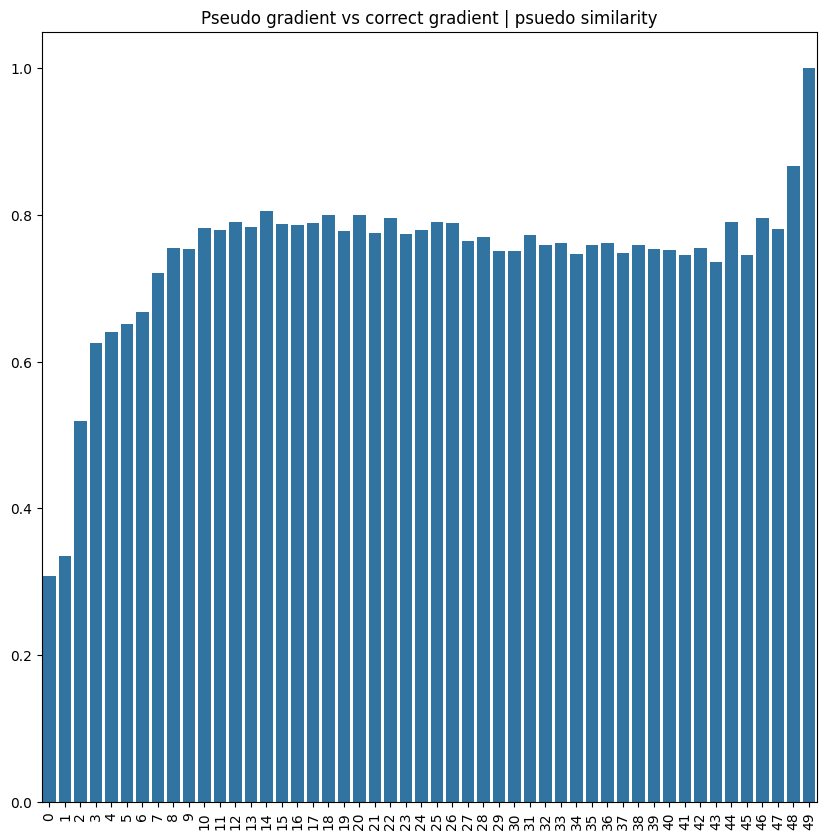

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis="x", rotation=90)
sns.barplot(
    [
        cosine_similarity(
            pseudo_gradient(t, params_per_round), correct_gradient(t, params_per_round)
        )
        for t in range(len(params_per_round) - 1)
    ]
).set_title("Pseudo gradient vs correct gradient | psuedo similarity")

**Question 10 (Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

 and then for

1.   Read about server momentum in FL [here](https://arxiv.org/abs/2003.00295) and repeat the previous experiments using `server_learning_rate=1.0` and `server_momentum=0.9`. Discuss how the momentum impacts the direction of optimization.




(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani